# Neural Network Hyperparameter Tuning

Greetings! In this notebook we will create a variety of neural networks to classify MNIST handwritten digits. In doing so, we will explore the impact of adjusting important hyperparameters, including:

* Batch Size
* Learning Rate
* Activation Functions

We will also experiment with adding more layers to the network.

This exploration is perfect for beginners who want to learn how to create neural networks using Keras.

Let's get started!

### Load the Good Stuff

In [2]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

### Load the Data

Keras gives us easy access to a handful of datasets - perfect for learning! (Learn more: [Keras Datasets](https://keras.io/datasets/))

In the MNIST dataset, each sample is a 28 x 28 px image.

* Train: 60,000 samples
* Valid: 10,000 samples

Load the data into numpy arrays:

In [4]:
(X_train, y_train), (X_valid, y_valid) = mnist.load_data()

In [5]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [6]:
type(X_train)

numpy.ndarray

The `X` arrays contain images of handwritten digits.

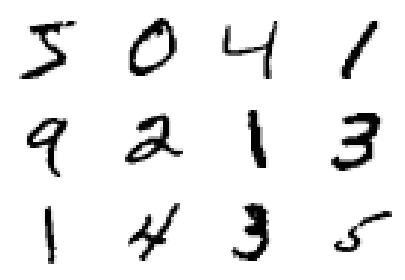

In [7]:
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(X_train[i], cmap="Greys")
    plt.axis("off")
plt.tight_layout()
plt.show()

The `y` arrays contain labels for the samples contained in `X`.

In [8]:
y_train[0:12]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5], dtype=uint8)

### Preprocessing

The simplest way to feed the 28 x 28 images into a neural network is to reshape them to 1D arrays of length 784 (`28 * 28 = 784`).

In [9]:
X_train = X_train.reshape(60000, 784).astype("float32")
X_valid = X_valid.reshape(10000, 784).astype("float32")

In [10]:
X_train.shape, X_valid.shape

((60000, 784), (10000, 784))

Normalizing the inputs aids the training process (increasing the speed and helping the neural network avoid local minima).

Here, pixel values are scaled by their max value (255), so that they range from 0 to 1.

In [12]:
X_train = X_train / 255
X_valid = X_valid / 255

We also need to address the target (aka label), which currently is a singled column vector containing the value (1-10) of each corresponding input image.

Here, we use Keras' built-in `to_categorical` method to convert the target into a one-hot encoded vector of length 10.

In [12]:
n = 10
y_train = keras.utils.to_categorical(y_train, num_classes=n)
y_valid = keras.utils.to_categorical(y_valid, num_classes=n)

In [14]:
y_train.shape, y_valid.shape

((60000, 10), (10000, 10))

### Modeling

Keras offers two methods for creating models: Sequential and Functional. 

Here, we use the Sequential method to design a shallow neural network with:

* One dense hidden layer with 64 sigmoid neurons and input size (784,1)
* One dense output layer with 10 softmax neurons

In [15]:
model = Sequential()
model.add(Dense(64, activation="sigmoid", input_shape=(784,)))
model.add(Dense(10, activation="softmax"))

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


The number of parameters in the hidden layer depends on the number of neurons in the hidden layer and in the shape of the input layer: $n_{param} = n_{weights} + n_{biases}$.

Do the number of parameters in the model summary make sense?

In [17]:
784 * 64 + 64 # 1 parameter for each of the 784 input neurons * 64 hidden neurons + 64 additional bias terms

50240

In [18]:
64 * 10 + 10 # 1 parameter for each of the 64 hidden layer neurons * 10 output neurons + 10 additional bias terms

650

In [19]:
(784 * 64 + 64) + (64 * 10 + 10) # total number of parameters

50890

Next, compile the model. Indicate the desired loss (cost) function and optimizer as well as an other additional metrics that should be calcualted during training.

In [20]:
model.compile(loss="mean_squared_error", optimizer=SGD(lr=0.01), metrics=["accuracy"])

Finally, fit the model to the training data. Passing in validation data enables the model to estimate performance on new observations.

In [21]:
hist = model.fit(x=X_train,
          y=y_train,
          batch_size=128,
          epochs=50,
          verbose=0, # Adjust to see training progress
          validation_data=(X_valid, y_valid))

### Evaluation

How did the model do? The learning curves illustrate how loss and accuracy changed over the course of training.

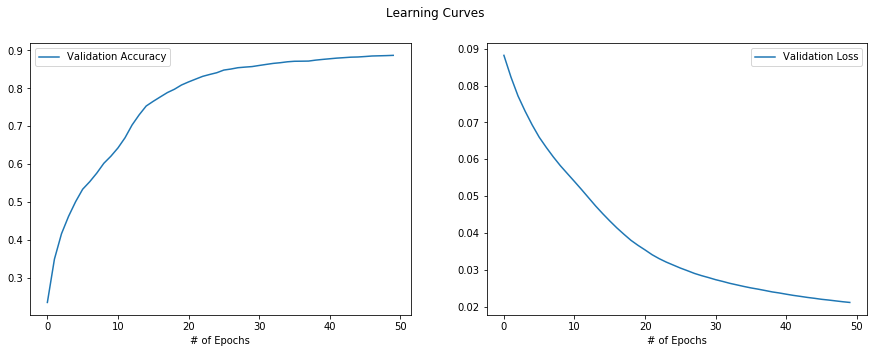

In [22]:
val_loss = hist.history["val_loss"]
val_accuracy = hist.history["val_accuracy"]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(x=range(0,len(val_accuracy)), y=val_accuracy, ax=ax[0], label="Validation Accuracy")
sns.lineplot(x=range(0,len(val_loss)), y=val_loss, ax=ax[1], label="Validation Loss")

ax[0].set_xlabel("# of Epochs")
ax[1].set_xlabel("# of Epochs")

plt.suptitle("Learning Curves")
plt.show()

To wrap things up, we can evaluate the model on the validation data to estimate test performance.

In [22]:
model.evaluate(X_valid, y_valid)

10000/10000 [==============================] - 0s 13us/step


[0.0846874517917633, 0.424699991941452]

### An Aside: Saving Models

As an aside, Keras makes it easy to save and load models to/from files, thus saving you from having to re-train!

In [23]:
model.save("working/model.hd5")
model = keras.models.load_model("working/model.hd5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


## Experimentation

Despite a lot going on under the hood, Keras makes it simple to create and apply a neural network.

Now, let's experiment with alternative model configurations, including:

* Different batch size
* Increased or decreased learning rate
* Additional hidden layers
* Alternative neuron activation functions

### Helper Functions

To reduce code duplication, the following wrapper class bundles Keras and plotting functionality together. Very handy :)

In [24]:
class NeuralNetwork():
    def __init__(self, name, batch_size, epochs, learning_rate, verbose):
        self.name = name
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.verbose = verbose
        self.model = Sequential()
        
    def add_(self, layer):
        self.model.add(layer)

    def compile_and_fit(self):
        self.model.compile(loss="mean_squared_error", optimizer=SGD(lr=self.learning_rate), metrics=["accuracy"])
        self.history = self.model.fit(x=X_train,
                                      y=y_train,
                                      batch_size=self.batch_size,
                                      epochs=self.epochs,
                                      verbose=self.verbose,
                                      validation_data=(X_valid, y_valid))
        self.val_loss = self.history.history["val_loss"]
        self.val_accuracy = self.history.history["val_accuracy"]
    
    def plot_learning_curves(self):
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
        
        sns.lineplot(x=range(0,len(self.val_accuracy)), y=self.val_accuracy, ax=ax[0], label="Validation Accuracy")
        sns.lineplot(x=range(0,len(self.val_loss)), y=self.val_loss, ax=ax[1], label="Validation Loss")

        ax[0].set_xlabel("# of Epochs")
        ax[1].set_xlabel("# of Epochs")

        plt.suptitle("Learning Curves: {}".format(self.name))
        plt.show()

    def evaluate_(self):
        return self.model.evaluate(X_valid, y_valid)
    
    def save(self, filename):
        self.model.save("working/"+filename+".hd5")
        
    def summary_(self):
        return self.model.summary()

In [25]:
def compare_learning_curves(models):
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    
    for model in models:
        sns.lineplot(x=range(0,len(model.val_accuracy)), y=model.val_accuracy, ax=ax[0], label=model.name)
        sns.lineplot(x=range(0,len(model.val_loss)), y=model.val_loss, ax=ax[1], label=model.name)
    
    ax[0].set_xlabel("# of Epochs")
    ax[1].set_xlabel("# of Epochs")

    ax[0].set_title("Validation Accuracy")
    ax[1].set_title("Validation Loss")

    plt.suptitle("Learning Curves")
    plt.show()

### Batch Size

Batch Size is a critical hyperparameter that controls how many training samples are passed through the model at a time. These inputs are processed via forward propagation to produce an output, which is then evaluated by the cost function. Finally, the weights and biases of all neurons are updated via gradient descent to generate better and better estimates.

Changing the batch size changes the number of training samples that are used to calculate the cost function. Too big a batch size can be computationally expensive and tends to create models that do not generalize as well. Too small a batch size can lead to lengthy training processes and wasteful use of resources.

Here we compare learning curves for a handful of models utilizing different batch sizes.

In [26]:
batch_sizes = [8, 16, 32, 64, 128, 256]
n_epochs = 50

In [27]:
accuracy = pd.DataFrame(columns=batch_sizes, index=range(n_epochs))
loss = pd.DataFrame(columns=batch_sizes, index=range(n_epochs))
accuracy["Epoch"] = range(n_epochs)
loss["Epoch"] = range(n_epochs)

In [28]:
for batch_size in batch_sizes:
    model = Sequential()
    model.add(Dense(64, activation="sigmoid", input_shape=(784,)))
    model.add(Dense(10, activation="softmax"))
    model.compile(loss="mean_squared_error", optimizer=SGD(lr=0.01), metrics=["accuracy"])
    
    hist = model.fit(x=X_train,
              y=y_train,
              batch_size=batch_size,
              epochs=n_epochs,
              verbose=0,
              validation_data=(X_valid, y_valid))
    
    accuracy[batch_size] = hist.history["val_accuracy"]
    loss[batch_size] = hist.history["val_loss"]

In [29]:
accuracy_melt = accuracy.melt(value_name="Accuracy", var_name="Batch Size", id_vars=["Epoch"])
loss_melt = loss.melt(value_name="Loss", var_name="Batch Size", id_vars=["Epoch"])

accuracy_melt["Batch Size"] = accuracy_melt["Batch Size"].astype(object)
loss_melt["Batch Size"] = loss_melt["Batch Size"].astype(object)

In [30]:
accuracy_melt = accuracy.melt(value_name="Accuracy", var_name="Batch Size", id_vars=["Epoch"])
loss_melt = loss.melt(value_name="Loss", var_name="Batch Size", id_vars=["Epoch"])

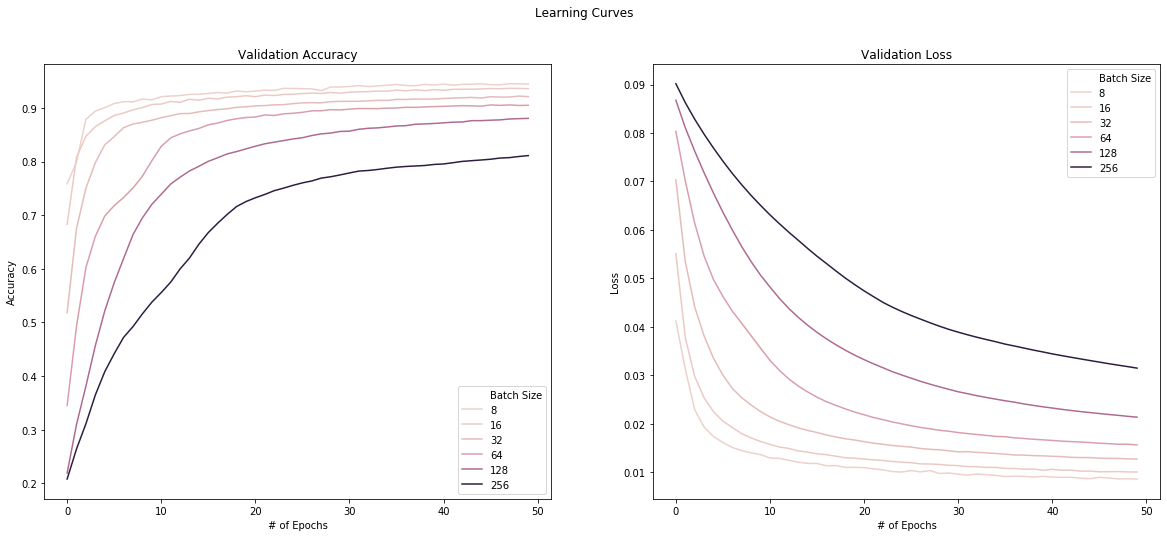

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.lineplot(x="Epoch", y="Accuracy", hue="Batch Size", data=accuracy_melt, ax=ax[0], legend="full")
sns.lineplot(x="Epoch", y="Loss", hue="Batch Size", data=loss_melt, ax=ax[1], legend="full")

ax[0].set_title("Validation Accuracy")
ax[1].set_title("Validation Loss")

ax[0].set_xlabel("# of Epochs")
ax[1].set_xlabel("# of Epochs")

plt.suptitle("Learning Curves")
plt.show()

**Observations**

Larger batch sizes are more stable, but slower to learn. In contrast, smaller batch sizes exhibit faster, but more erratic, learning.

### Learning Rate

The learning rate, $\eta$, controls the step size of gradient descent. In other words, it controls the magnitude of the adjustments made to model weights and biases

Large learning rates require fewer training epochs, but can cause unstable training and failure to converge to the optimal solution. On the other hand, small learning rates are more stable, but require more training epochs and are computationally inefficient.

Let's tweak the learning rate and observe the impact.

In [41]:
n_epochs = 100
batch_size = 128
verbose = 0

In [42]:
learning_rate = 100
nn_lr_100 = NeuralNetwork("LR = {}".format(learning_rate), batch_size, n_epochs, learning_rate, verbose)
nn_lr_100.add_(Dense(64, activation="sigmoid", input_shape=(784,)))
nn_lr_100.add_(Dense(10, activation="softmax"))

learning_rate = 1000
nn_lr_1000 = NeuralNetwork("LR = {}".format(learning_rate), batch_size, n_epochs, learning_rate, verbose)
nn_lr_1000.add_(Dense(64, activation="sigmoid", input_shape=(784,)))
nn_lr_1000.add_(Dense(10, activation="softmax"))

learning_rate = 10
nn_lr_10 = NeuralNetwork("LR = {}".format(learning_rate), batch_size, n_epochs, learning_rate, verbose)
nn_lr_10.add_(Dense(64, activation="sigmoid", input_shape=(784,)))
nn_lr_10.add_(Dense(10, activation="softmax"))

learning_rate = 1
nn_lr_1 = NeuralNetwork("LR = {}".format(learning_rate), batch_size, n_epochs, learning_rate, verbose)
nn_lr_1.add_(Dense(64, activation="sigmoid", input_shape=(784,)))
nn_lr_1.add_(Dense(10, activation="softmax"))

learning_rate = 0.1
nn_lr_p1 = NeuralNetwork("LR = {}".format(learning_rate), batch_size, n_epochs, learning_rate, verbose)
nn_lr_p1.add_(Dense(64, activation="sigmoid", input_shape=(784,)))
nn_lr_p1.add_(Dense(10, activation="softmax"))

learning_rate = 0.01 # default
nn_lr_p01 = NeuralNetwork("LR = {}".format(learning_rate), batch_size, n_epochs, learning_rate, verbose)
nn_lr_p01.add_(Dense(64, activation="sigmoid", input_shape=(784,)))
nn_lr_p01.add_(Dense(10, activation="softmax"))

learning_rate = 0.001
nn_lr_p001 = NeuralNetwork("LR = {}".format(learning_rate), batch_size, n_epochs, learning_rate, verbose)
nn_lr_p001.add_(Dense(64, activation="sigmoid", input_shape=(784,)))
nn_lr_p001.add_(Dense(10, activation="softmax"))

nn_lr_100.compile_and_fit()
nn_lr_1000.compile_and_fit()
nn_lr_10.compile_and_fit()
nn_lr_1.compile_and_fit()
nn_lr_p1.compile_and_fit()
nn_lr_p01.compile_and_fit()
nn_lr_p001.compile_and_fit()

In [57]:
learning_rate = 0.1
nn_lr_p1 = NeuralNetwork("LR = {}".format(learning_rate), batch_size, n_epochs, learning_rate, verbose)
nn_lr_p1.add_(Dense(64, activation="sigmoid", input_shape=(784,)))
nn_lr_p1.add_(Dense(10, activation="softmax"))
nn_lr_p1.compile_and_fit()

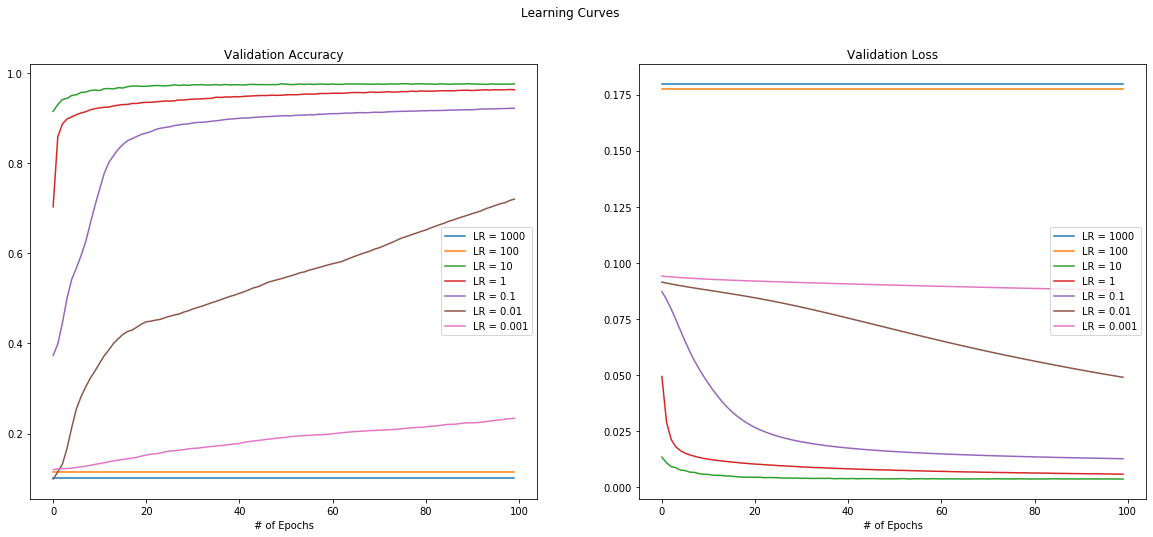

In [49]:
compare_learning_curves([nn_lr_1000, nn_lr_100, nn_lr_10, nn_lr_1, nn_lr_p1, nn_lr_p01, nn_lr_p001])

In particular, notice the training instability visible at higher LR values, for example `LR=10`:

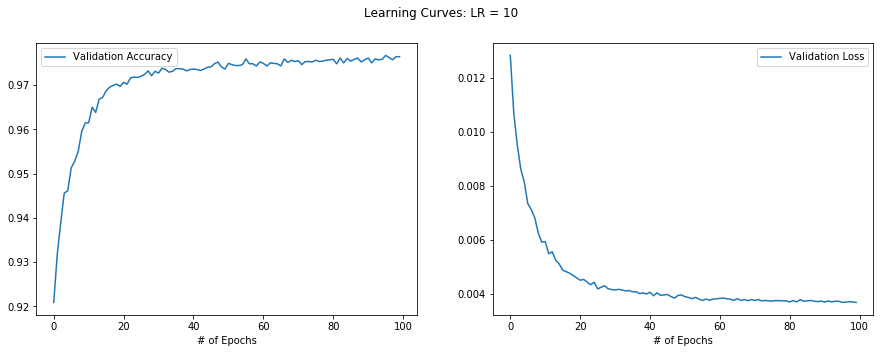

In [53]:
nn_lr_10.plot_learning_curves()

In contrast, there is minimal training instability at `LR<10`, however models take more epochs to reach their full potential:

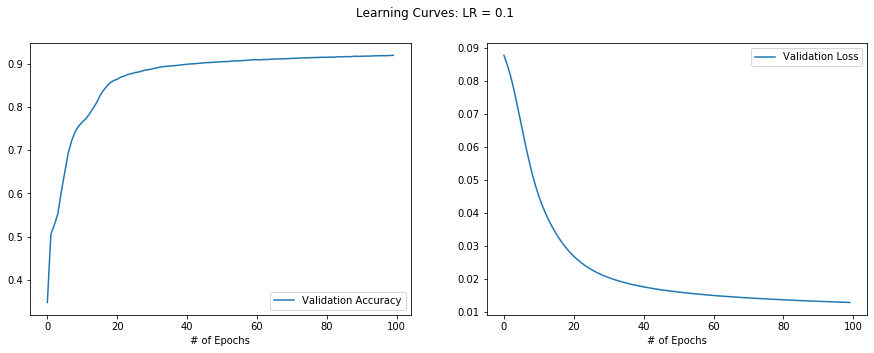

In [58]:
nn_lr_p1.plot_learning_curves()

**Observations**

Learning rates greater than 10 were unable to converge to a solution (at least not within 100 epochs), resulting in poor accuracy and high loss. A learning rate of 10 was the fastest to reach optimal accuracy and loss. This is as expected: large learning rates increase the magnitude of parameter updates and therefore speed up training. There were, however, slight oscillations in the learning curves for `LR=10`, illustrating some training instability. This instability is not visible at smaller learning rates, at the cost of slower training.

### Additional Hidden Layers

In practice, neural networks rarely consist of only 3 layers. Additional hidden layers are added to enable models to extract increasingly high level representations from the data, suitable for complex applications. 

Here, we compare models with one, two and three hidden layers. Of course, you can also adjust the number of neurons in each layer, but for simplicity, we've stuck with a static 64 units.

In [127]:
n_epochs = 100
batch_size = 128
learning_rate = 0.01
verbose = 1

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_75 (Dense)             (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 1s 19us/step - loss: 0.0946 - accuracy: 0.1026 - val_loss: 0.0932 - val_accuracy: 0.1094
Epoch 2/100
60000/60000 [==============================] - 1s 12us/step - loss: 0.0927 - accuracy: 0.1183 - val_loss: 0.0919 - val_accuracy: 0.1339
Epoch 3/100
60000/60000 [==============================] - 1s 13us/step - loss: 0.0916 - accuracy: 0.1470 - val_loss: 0.0910 - val_accuracy: 0.1636
Epoch 4/100
60000

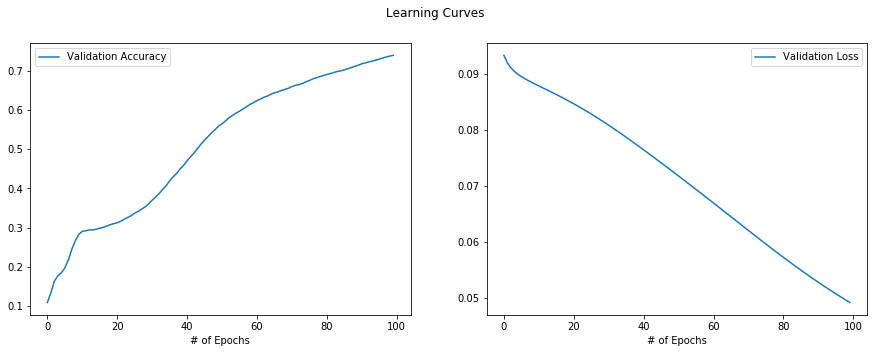

In [122]:
nn_l1 = NeuralNetwork("1 Hidden Layer", batch_size, n_epochs, learning_rate, verbose)
nn_l1.add_(Dense(64, activation="sigmoid", input_shape=(784,)))
nn_l1.add_(Dense(10, activation="softmax"))

nn_l1.summary_()
nn_l1.compile_and_fit()
nn_l1.plot_learning_curves()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_76 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_77 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_78 (Dense)             (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 1s 24us/step - loss: 0.0934 - accuracy: 0.0976 - val_loss: 0.0929 - val_accuracy: 0.0968
Epoch 2/100
60000/60000 [==============================] - 1s 15us/step - loss: 0.0927 - accuracy: 0.1006 - val_loss: 0.0923 - val_accuracy: 0.1004
Epoch 3/100
60000/60000 [========

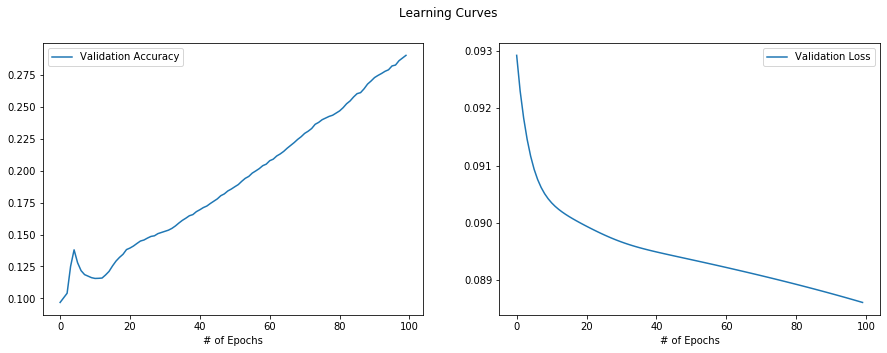

In [123]:
nn_l2 = NeuralNetwork("2 Hidden Layers", batch_size, n_epochs, learning_rate, verbose)
nn_l2.add_(Dense(64, activation="sigmoid", input_shape=(784,)))
nn_l2.add_(Dense(64, activation="sigmoid"))
nn_l2.add_(Dense(10, activation="softmax"))

nn_l2.summary_()
nn_l2.compile_and_fit()
nn_l2.plot_learning_curves()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_79 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_80 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_81 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_82 (Dense)             (None, 10)                650       
Total params: 59,210
Trainable params: 59,210
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 2s 26us/step - loss: 0.0931 - accuracy: 0.0975 - val_loss: 0.0926 - val_accuracy: 0.0974
Epoch 2/100
60000/60000 [========================

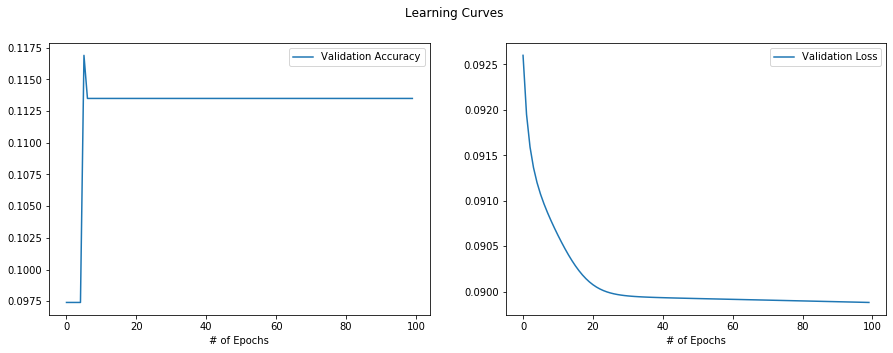

In [124]:
nn_l3 = NeuralNetwork("3 Hidden Layers", batch_size, n_epochs, learning_rate, verbose)
nn_l3.add_(Dense(64, activation="sigmoid", input_shape=(784,)))
nn_l3.add_(Dense(64, activation="sigmoid"))
nn_l3.add_(Dense(64, activation="sigmoid"))
nn_l3.add_(Dense(10, activation="softmax"))

nn_l3.summary_()
nn_l3.compile_and_fit()
nn_l3.plot_learning_curves()

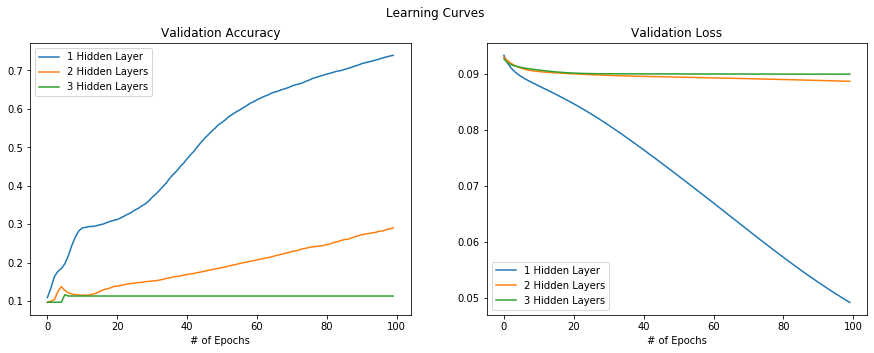

In [125]:
compare_learning_curves([nn_l1, nn_l2, nn_l3])

**Observations**

In this instance, additional hidden layers do not improve accuracy or decrease loss, at least not in the first 100 epochs. In general, if the number of hidden layers is inconsistent with the complexity of the problem, the network tends to overfit the training data. Trial and error is often necesary to determine the optimal architecture for a given problem.

### Activation Functions

An activation function translates the weighted sum of a neuron's inputs and bias terms into an output that is passed further along the network. There are many different activation functions, each with varying applications. The key is for the activation function to be non-linear; this gives deep learning models the power of universal function approximators - a fancy way of saying that they can estimate any output `y` given some input `x`.

The last thing we'll look at is what happens when we substitute the `sigmoid` activation function with two popular alternatives: `tanh` and `relu`.

In [133]:
n_epochs = 100
batch_size = 128
learning_rate = 0.01
verbose = 0

In [134]:
nn_sigmoid = NeuralNetwork("Sigmoid", batch_size, n_epochs, learning_rate, verbose)
nn_sigmoid.add_(Dense(64, activation="sigmoid", input_shape=(784,)))
nn_sigmoid.add_(Dense(10, activation="softmax"))
nn_sigmoid.compile_and_fit()

nn_tanh = NeuralNetwork("Tanh", batch_size, n_epochs, learning_rate, verbose)
nn_tanh.add_(Dense(64, activation="tanh", input_shape=(784,)))
nn_tanh.add_(Dense(10, activation="softmax"))
nn_tanh.compile_and_fit()

nn_relu = NeuralNetwork("ReLU", batch_size, n_epochs, learning_rate, verbose)
nn_relu.add_(Dense(64, activation="relu", input_shape=(784,)))
nn_relu.add_(Dense(10, activation="softmax"))
nn_relu.compile_and_fit()

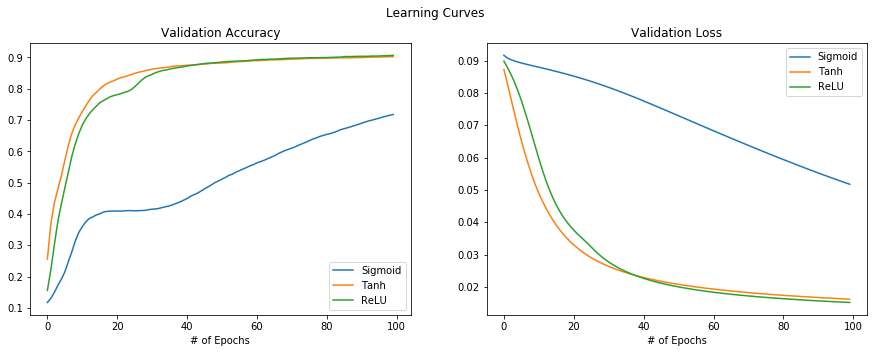

In [135]:
compare_learning_curves([nn_sigmoid, nn_tanh, nn_relu])

**Observations**

The `tanh` and `relu` activation functions easily outperform `sigmoid` in terms of more quickly reaching peak accuracy and minimum loss. It should come as no surprise that `relu` is the most widely used activation function - when in doubt, use `relu`!

### Conclusion

I hope you have enjoyed learning more about tuning neural network hyperparameters in the context of the MNIST dataset.

Thanks for reading and, until next time, happy coding :)